# 1. Imports

In [40]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms, datasets
import torch.optim as optim
from tqdm import tqdm



# 2. Dataset und DataLoader

In [41]:
# Pfad zum Datenordner (wo 'clean' und 'stego' liegen)
data_dir = r"C:\Users\Flavio\Bachelorarbeit\LSB\data_LSB"

# Transformation:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])


full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

print("Klassen zu Indizes:", full_dataset.class_to_idx)
print("Total images:", len(full_dataset))


Klassen zu Indizes: {'clean': 0, 'stego': 1}
Total images: 70000


# 3. Train-/Val-/Test-Split

In [42]:
# Split: 80% Train, 10% Val, 10% Test
train_size = int(0.8 * len(full_dataset))
val_size   = int(0.1 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # für reproduzierbare Splits
)

# DataLoader
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Train:", len(train_dataset), "Val:", len(val_dataset), "Test:", len(test_dataset))


Train: 56000 Val: 7000 Test: 7000


# 4. High-Pass-Filter-Layer (optional)

In [43]:
class HighpassConv(nn.Module):
    def __init__(self):
        super(HighpassConv, self).__init__()
        # Laplacian Filter (3x3); 
        kernel = torch.tensor([[0, -1, 0],
                               [-1, 4, -1],
                               [0, -1, 0]], dtype=torch.float32)
        # 1x1-Conv-Layer mit diesem Filter als festen Filter
        self.conv = nn.Conv2d(1, 1, kernel_size=3, padding=1, bias=False)
        # Gewichte setzen und einfrieren (man könnte auch feintuning erlauben)
        self.conv.weight.data = kernel.unsqueeze(0).unsqueeze(0)
        self.conv.weight.requires_grad = False  # hier true für feintuning

    def forward(self, x):
        return self.conv(x)

# 5. Residual Block (vereinfacht)

In [44]:
class ResidualBlock(nn.Module):
    def __init__(self, channels, dilation=1, use_batchnorm=True):
        super(ResidualBlock, self).__init__()
        padding = dilation  # räumliche Auflösung erhalten
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels) if use_batchnorm else nn.Identity()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += residual
        return self.relu(out)

# 6. Das Hauptmodell

In [45]:
class SteganoNet(nn.Module):
    def __init__(self, use_highpass=True):
        super(SteganoNet, self).__init__()
        self.use_highpass = use_highpass

        # Highpass Filter benutzen oder nicht
        if self.use_highpass:
            self.highpass = HighpassConv()
        else:
            self.highpass = nn.Identity()

        # Erste Convolution um Kanaldimension auf einen höheren Wert zu bringen (32)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)

        # Mehrere Residual-Blöcke mit unterschiedlichen Dilatationsfaktoren I
        # => Informationen auf verschiedenen Skalen erfassen
        self.resblock1 = ResidualBlock(32, dilation=1)
        self.resblock2 = ResidualBlock(32, dilation=1)
        self.resblock3 = ResidualBlock(32, dilation=2)
        self.resblock4 = ResidualBlock(32, dilation=2)
        
        # Gegen Overfitting
        self.dropout = nn.Dropout(0.25)
        
        # Kein Pooling! Evtl dann aber bei komplexeren Bildern
        # Leichte Reduktion für globale Zusammenhänge => wichtig wenn ich anders embedde (zB mit WOW)
        # strided conv halbiert Auflösung
        self.downsample = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn_down = nn.BatchNorm2d(64)
        
        # Weitere Residual Blöcke im kleineren (64-Channel) Feature-Raum
        self.resblock5 = ResidualBlock(64, dilation=1)
        self.resblock6 = ResidualBlock(64, dilation=1)
        
        # Global Average Pooling, um von 2D-Feature-Maps auf einen Vektor zu kommen
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        # Abschließende Klassifikation mit 2 Klassen stego&clean
        self.fc = nn.Linear(64, 2)

    def forward(self, x):
        # Highpass-Filter
        x = self.highpass(x)
        
        # Erste Feature-Extraktion
        x = self.relu(self.bn1(self.conv1(x)))
        
        # Mehrere Residual-Blöcke (ohne Änderung der Auflösung)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        
        # Gegen Overfitting
        x = self.dropout(x)
        
        # Downsampling
        x = self.relu(self.bn_down(self.downsample(x)))
        
        # Mehr res Blöcke/ kleinerer aber reicher Feature Raum
        x = self.resblock5(x)
        x = self.resblock6(x)
        
        # Global Average Pooling zur Reduktion auf einen Feature-Vektor
        x = self.global_pool(x)  # [Batch, 64, 1, 1]
        x = torch.flatten(x, 1)  # [Batch, 64]
        x = self.fc(x)           # [Batch, 2] (logits für 2 Klassen)
        return x

# 7. Training & Validierung

In [46]:
# 3. Modell und Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SteganoNet(use_highpass=True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

# 4. Training und Validierung
def train(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)

        # Forward-Pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward-Pass und Optimierung
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Metriken aktualisieren
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Validation", leave=False):
            images, labels = images.to(device), labels.to(device)

            # Forward-Pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Metriken aktualisieren
            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

# Haupt-Trainingsloop
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_acc:.4f}\n")

print("Training abgeschlossen.")

Epoch 1/5


Train Loss: 0.0149 | Train Accuracy: 0.9922
Val Loss: 0.0000 | Val Accuracy: 1.0000

Epoch 2/5


Train Loss: 0.0000 | Train Accuracy: 1.0000
Val Loss: 0.0000 | Val Accuracy: 1.0000

Epoch 3/5


Train Loss: 0.0000 | Train Accuracy: 1.0000
Val Loss: 0.0000 | Val Accuracy: 1.0000

Epoch 4/5


Train Loss: 0.0000 | Train Accuracy: 1.0000
Val Loss: 0.0000 | Val Accuracy: 1.0000

Epoch 5/5


Train Loss: 0.0000 | Train Accuracy: 1.0000
Val Loss: 0.0000 | Val Accuracy: 1.0000

Training abgeschlossen.


# 8. Testen auf dem Test-Set

In [47]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for test_x, test_y in test_loader:
        test_x = test_x.to(device)
        test_y = test_y.to(device)
        
        outputs = model(test_x)
        loss_val = criterion(outputs, test_y)
        test_loss += loss_val.item()
        
        _, predicted = outputs.max(1)
        correct += (predicted == test_y).sum().item()
        total += test_y.size(0)

test_loss /= len(test_loader)
test_acc = correct / total
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")


Test Loss: 0.0000, Test Accuracy: 1.0000


In [48]:
model.eval()  # Modell in Evaluierungsmodus
all_predictions = {}

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)  # Wahrscheinlichkeiten für jede Klasse
        preds = probabilities.argmax(dim=1)  # Höchste Wahrscheinlichkeiten
        
        # Speichere Ergebnisse in einem Dictionary
        for i, (prob, pred, label) in enumerate(zip(probabilities, preds, labels)):
            all_predictions[i] = {
                "true_label": label.item(),
                "predicted_label": pred.item(),
                "probability": prob[pred].item(),  # Wahrscheinlichkeit vorhergesagter Klasse
            }

for idx, result in all_predictions.items():
    print(
        f"Bild-Index: {idx}  ->  "
        f"True Label: {result['true_label']}  |  "
        f"Vorhersage: {result['predicted_label']}  |  "
        f"Wahrscheinlichkeit: {result['probability']:.4f}"
    )


Bild-Index: 0  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 1  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 2  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 3  ->  True Label: 0  |  Vorhersage: 0  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 4  ->  True Label: 0  |  Vorhersage: 0  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 5  ->  True Label: 0  |  Vorhersage: 0  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 6  ->  True Label: 0  |  Vorhersage: 0  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 7  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 8  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 9  ->  True Label: 0  |  Vorhersage: 0  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 10  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 11  ->  True Label: 1  |  Vorhersage: 1  |  Wahrscheinlichkeit: 1.0000
Bild-Index: 12

## 9. Weitere Analyse

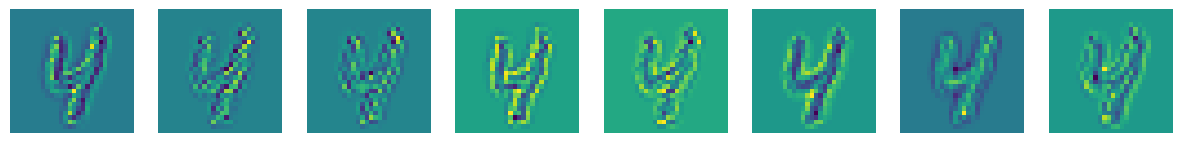

In [49]:
import matplotlib.pyplot as plt

# Visualisierung der Feature Maps
def visualize_feature_maps(model, image):
    model.eval()
    activations = []
    
    # Aktivierungen speichern
    def hook_fn(module, input, output):
        activations.append(output)
    
    # Registriere Hook auf gewünschter Schicht
    layer = model.conv1  # Schicht die ich haben will
    hook = layer.register_forward_hook(hook_fn)
    
    # Leite Bild durch Modell
    #with torch.no_grad():
    image = image.unsqueeze(0).to(device)  # Batch-Dimension hinzufügen
    model(image)
    
    # Entferne Hook
    hook.remove()
    
    # Feature Maps visualisieren
    feature_maps = activations[0].cpu().squeeze(0)  # Batch-Dimension entfernen
    num_maps = feature_maps.shape[0]
    
    fig, axes = plt.subplots(1, min(8, num_maps), figsize=(15, 15))
    for i in range(min(8, num_maps)):  # Anzahl an Karten die angezeigt werden
        ax = axes[i]
        ax.imshow(feature_maps[i].detach().numpy(), cmap='viridis')
        ax.axis('off')
    plt.show()

# Aufruf
test_image, _ = test_dataset[0]
visualize_feature_maps(model, test_image)


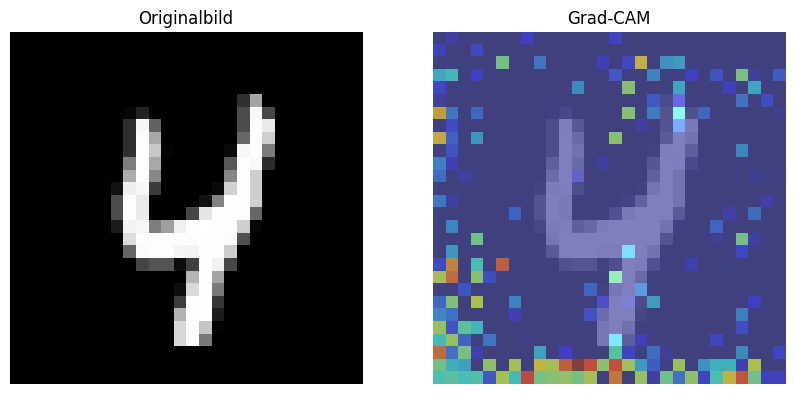

In [50]:
from torchcam.methods import SmoothGradCAMpp
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

# Grad-CAM-Objekt erstellen und Zielschicht anpassen (z. B. letzte Convolutional-Schicht)
target_layer = model.resblock4.conv2
cam_extractor = SmoothGradCAMpp(model, target_layer=target_layer)


model.eval()  # Evaluierungsmodus
image, _ = test_dataset[0]  # Bild auswählen
input_tensor = image.unsqueeze(0).to(device)  # Batch-Dimension hinzufügen

# Vorhersage
output = model(input_tensor)
prediction = output.argmax(dim=1).item()

# Grad-CAM-Karte berechnen
activation_map = cam_extractor(prediction, output)

# Visualisieren
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Originalbild")
plt.imshow(image.squeeze(0).cpu().numpy(), cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(image.squeeze(0).cpu().numpy(), cmap='gray', alpha=0.5)  # Originalbild
plt.imshow(activation_map[0].squeeze().cpu().numpy(), cmap='jet', alpha=0.5)  # Grad-CAM-Karte
plt.axis('off')

plt.show()


## 10. To Do`s

Sachen noch zum Evaluieren des Models:
- versch. Highpass Filter verwenden, gucken was passiert (ist jetziger Optimal?)
- nachsehen inwiefern der die entscheidenen Pixel gehighlighted werden (mit Grad-Cam Pixel Highlights ansehen und dann schauen welche Pixel am meisten verändert wurden zum original Bild)
- andere Stego implemetierungen nutzen/ sehen ob das auch erkennt wird S- Uniward oder WOW zb
- Model struktur evtl. nochmals anpassen => wie reagiert es darauf => rausfinden was jetzt der springende Punkt war
- model auf härtere Daten testen => bis auf wie viel byte embeddete Daten kann ich runter gehen??


Ansonsten:
- implementieren einer SVM die das Probolem lösen kann (Im Titel steht comparative Study) => wäre interessant zu sehen wie andere RL Algorithmen performen => starkes Preprocessing durch X2 usw. nötig
- Schreiben anfangen!! Dann sehen wie viel Zeit übrig ist für weitere Untersuchungen
- Falls ich nochmal komplexere Daten verwende denken an: Daten-Augmentierung, Hyperparametertuning, Curriculum Training, Early Stopping, Learning-Rate-Scheduler, Cross-Validation 

